## Classification of Tweets about Disaster Using Roberta

Below is a sample code to fine-tune Roberta model for annotated tweets that are labeled as "not about disaster" (0) or "about disaster" (1).

#### Step 1: Download Packages

In [1]:
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments, RobertaForSequenceClassification, \
     RobertaTokenizerFast,DataCollatorWithPadding, pipeline
from datasets import load_metric, Dataset
import numpy as np
import evaluate
import pandas as pd
import sklearn
import re
import os
import torch
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from matplotlib.pylab import plt
from numpy import arange

pd.set_option('display.max_colwidth', None)
os.environ["WANDB_DISABLED"] = "true"
torch.manual_seed(123)

#InteractiveShell.ast_node_interactivity = "all"  
#from IPython.core.interactiveshell import InteractiveShell 

/Users/volhakatebi/miniconda3/envs/transformers/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Step 2: Download Tokenizer and Model

In [2]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)
sequence_clf_model = RobertaForSequenceClassification.from_pretrained('roberta-base', hidden_dropout_prob=0.2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [3]:
#ensure that tokenizer and model have the same number of unique tokens
sequence_clf_model.resize_token_embeddings((len(tokenizer)))
print(sequence_clf_model.config.vocab_size)
len(tokenizer)

50265


50265

#### Step 3: Download Data & Check Counts for Each Class

In [4]:
df_disaster = pd.read_csv("train.csv", encoding='utf-8', nrows=1000)
df_disaster = df_disaster[["text", "target"]]
df_disaster.head(2)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1


In [5]:
df_disaster.shape #train model on 1000 data points
df_disaster.groupby('target').size() #number of data points in each class

target
0    695
1    305
dtype: int64

#### Step 4: Basic Data Preprocessing

* **prune_multple_consecutive_same_char** will make words like yessssss into yess
* **clean_tweet** will lowercase; remove \n; remove meaningless common symbols; strip extra white spaces

In [6]:
def prune_multple_consecutive_same_char(tweet_text):
    '''
    yesssssssss  is converted to yes
    ssssssssssh is converted to ssh
    '''
    tweet_text = re.sub(r'(.)\1+', r'\1\1', tweet_text)
    return tweet_text

prune_multple_consecutive_same_char("yessss!!!!")

'yess!!'

In [7]:
#remove emoji
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [8]:
def clean_tweet(text):
    text = text.lower()
    text = prune_multple_consecutive_same_char(text)
    text = remove_emojis(text) 
    text = text.replace('\\n', '')
    text = re.sub(r'http\S+', '', text) 
    text = re.sub("@[A-Za-z0-9_]+",'', text)
    text = text.encode('ascii',errors='ignore').decode()
    text = re.sub("^\s+|\s+$", "", text, flags=re.UNICODE)
    text = " ".join(re.split("\s+", text, flags=re.UNICODE))
    return text

In [9]:
df_disaster.loc[:, "clean_text"] = df_disaster.loc[:, "text"].apply(clean_tweet)#run function for each tweet

In [10]:
df_disaster[1:2]

,text,target,clean_text
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada


#### Step 5: Prepare Data for the Models in a Manageable Format

* put tweets & labels in separate lists

In [11]:
tweets = df_disaster["clean_text"].values.tolist()
sequence_labels = df_disaster["target"].values.tolist()


* print the length of documents/tweets and labels to make sure we have the same number

In [12]:
print("Number of tweets:",len(tweets))
print("Number of labels:",len(sequence_labels))

Number of tweets: 1000
Number of labels: 1000


* print an example of a tweet and label in the list to make sure everything looks as expected

In [13]:
print("Example of a tweet in the list:", tweets[0])

Example of a tweet in the list: our deeds are the reason of this #earthquake may allah forgive us all


In [14]:
print("Example of a label in the list:", sequence_labels[0])

Example of a label in the list: 1


* print all unique labels

In [15]:
unique_sequence_labels = list(set(sequence_labels))
print("List of all unique labels:", unique_sequence_labels)

List of all unique labels: [0, 1]


#### Step 5: Split Data into Train-Test and Prepare for Modeling

* put data in the dataset object; need to specify dictionary structure

In [16]:
our_dataset = Dataset.from_dict(
    dict(
        tweets=tweets, 
        label=sequence_labels))

In [17]:
print(our_dataset)

Dataset({
    features: ['tweets', 'label'],
    num_rows: 1000
})


In [18]:
print("Example of one element in the dataset object:") 
our_dataset[0]

Example of one element in the dataset object:


{'tweets': 'our deeds are the reason of this #earthquake may allah forgive us all',
 'label': 1}

* divide data into train-test

In [19]:
our_dataset = our_dataset.train_test_split(test_size=0.2, seed=123)

In [20]:
our_dataset['test'][:2]

{'tweets': ['did anyone else see that fireball falling to earth? look like a plane blew up.',
  'i want a full on bitch slapping guns blazing cake throwing charles showdown!! now that will be worth the wait ??'],
 'label': [1, 0]}

our_dataset['train'][:]Access a single example in train or test data to check it:

In [21]:
our_dataset['train'][:2]

{'tweets': ['320 [ir] icemoon [aftershock] | | | #dubstep #trapmusic #dnb #edm #dance #ices_',
  'and my mentions are blown up for what? ?? wtf.'],
 'label': [0, 0]}

* check counts of lables in train & test splits

In [22]:
print("Number of tweets with label 0 in train data:")
our_dataset['train']['label'].count(0) 

print("Number of tweets with label 1 in train data:")
our_dataset['train']['label'].count(1)

print("Number of tweets with label 0 in test data:")
our_dataset['test']['label'].count(0) 

print("Number of tweets with label 1 in test data:")
our_dataset['test']['label'].count(1)

Number of tweets with label 0 in train data:
Number of tweets with label 1 in train data:
Number of tweets with label 0 in test data:
Number of tweets with label 1 in test data:


64

#### Step 6 (Optional): Check How Encodings Get Created on a Single Example

Explanation of parameters after tokenization:

* **input_ids**: numeric inputs for tokens
* the **first token** shows id for **CLS token**, which is used as a representation of the whole tweet and includes all contextual information
* the **last token** in the input_id is usually a numeric representation for a separator token
* thus, encoded tweet will have the following structure: **[cls token id], [ids for actual tokens], [id for token that indicates end of the tweet]**
* **toke_type_ids**: for classification, it should include all 0s. It will only be different for next sentence prediction task where 0s will indicate sentence A and 1s will indicate sentence B
* **attention_mask**: shows what tokens will be attended to or not; for those that are not attended we will have value 0. Usually, 0s will be used for tokens indicating paddings, since they are contextually meaningless. 
* In the example below, we specify to cut everything that is longer than 200 words thorugh **truncation** & **max_length** functions; we also asked to add tokens for sentences that are shorter than max length through **padding** function (in reality, we add paddings to match max length in a batch of data)

In [23]:
print("Encoding structure for a single tweet:")
tokenizer('Hello this is a sample tweet to check @volhakat http/www.red',max_length=200, truncation=True, padding='max_length')

Encoding structure for a single tweet:


{'input_ids': [0, 31414, 42, 16, 10, 7728, 3545, 7, 1649, 787, 13728, 28832, 415, 2054, 73, 1401, 4, 2050, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

As a proofcheck that everything works as planned, we can also decode encodings into words again based on input IDs to see how that looks like with these newly added additional tokens. 
* To do that, use the vector from **input_ids** key for **tokenizer.decode** function

In [24]:
tokenizer.decode([0, 31414, 42, 16, 10, 7728, 3545, 7, 1649, 787, 13728, 28832, 415, 2054, 73, 1401, 4, 2050, 2])

'<s>Hello this is a sample tweet to check @volhakat http/www.red</s>'

* Note that the output above may show:
* **< s >** means CLS token representing whole sentence
* **< /s >** means a separator token
* **< pad >** is a padding token to match the length of the longest tweet in the bach

#### Step 7: Prepare Tweets for the Model

* We can repeat the same procedures (i.e., padding, truncation) for each batch.
* **batch=True** makes it run a bit faster

In [25]:
def preprocess_function(examples):
    return tokenizer(examples["tweets"], truncation=True, padding = True, verbose=True) 

In [26]:
seq_clf_tokenized_tweets = our_dataset.map(preprocess_function, batched=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

* DataCollatorWithPadding is used in train function. It creates batches of data and dynamically pads text to the length of the longest element in the **batch** making them all the same length **within this batch**. It's also possible to pad your text in the **tokenizer** function with padding=True; however, dynamic padding (the one in the datacollator) is more efficient. Note that padding happening **on the right side** of the tweet. All these paddings will be ignored by attention mask (i.e., paddings should not be attended to by the model).

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
data_collator

DataCollatorWithPadding(tokenizer=RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

* We can also see how our labels are tranformed into the inputs for the model. Note that we will not see a lot of differences because we have the same labels (0,1) as the default labels in the model (0,1). However, if we had categorical variables, we could see how they can be transformed into numeric labels.This dictionary includes **the following format**: {model_integer: original_string; model_integer: original_string}

In [28]:
sequence_clf_model.config.id2label = {i: l for i, l in enumerate(unique_sequence_labels)}
print("Sumamry of model labels and actual labels:")
sequence_clf_model.config.id2label 

Sumamry of model labels and actual labels:


{0: 0, 1: 1}

#### Step 8: Prepare Arguments and Metrics for the Model

Hugginface automatically calculates loss as its main metrics. Thus, we create a custom one to calculate f1 score.
* custom method to take in logits and calculate accuracy/f1 score of the eval set
* **eval_pred** comes directly from our training object; transformer object that appears during training stage
* **eval_pred** has logits and labels
* **logits** is a matrix of labels/matrix logits where n of rows is N of elements in batch; n of columns is N of sequence labels that we have
* example of logit for one tweet: -0.46910447 -0.28945872 for 0 and 1 equavalent to 0.38 and 0.43 probs for 0 and 1. Then these values are compared against actual labels.
* **labels** are actual labels/ground truth labels
* **predictions** assign prediction to that index of the logit(0 or 1) that is higher(e.g., closer to 0 if negative)
* to add **accuracy** measure, use: metric = evaluate.load("accuracy")

In [29]:
def compute_metrics(eval_pred):
    average = "macro"
    d = {}
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = sklearn.metrics.f1_score(labels, predictions, average=average)
    recall = sklearn.metrics.recall_score(labels, predictions, average=average)
    precision = sklearn.metrics.precision_score(labels, predictions, average=average)
    d["f1"] = f1
    d["recall"] = recall
    d["precision"] = precision
    return d

In the next block of code, we specify **Model Training Arguments** including:
* number of **epochs** (suggested minimum=2; we should not go too high on this measure)
* specify output directory **output_dir** to save checkpoints of the model
* **batch_size** for train and evaluation
* ask to load the model with the lowest evaluation loss **load_best_model_at_end**
* **warmup_steps** is the number of warmup steps for learning rate scheduler; to avoid early-on overfitting by falling into a local minimum
* **weight_decay** is penalty to the loss function
* **logging_steps** is the minimal number of steps that we want to log between (better to log as much as possible)
* **log_level='info'** outputs more logs than the standard variety
* **evaluation_strategy='epoch'** how often we want to stop training and evaluate on our test set to check in how our model is doing; here we ask to evaluate model every epoch
* **save_strategy='epoch'** we are going to save this model as many times as many epochs we have

In [30]:
epochs = 5

training_args = TrainingArguments(
    output_dir="./model_disaster/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=64,  
    load_best_model_at_end=True, 
    warmup_steps=len(seq_clf_tokenized_tweets['train']) // 5, 
    weight_decay = 0.01,
    logging_steps=1,
    log_level='info', 
    evaluation_strategy='epoch', 
    #eval_steps=50,
    save_strategy='epoch',
    learning_rate = 4e-5
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model, #model
    args=training_args, #from above
    train_dataset=seq_clf_tokenized_tweets['train'],
    eval_dataset=seq_clf_tokenized_tweets['test'],
    compute_metrics=compute_metrics, #our custom function from above
    data_collator=data_collator #use our custom data collator from above for padding
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


#### Step 9: Run & Save the Model
* **Get initial metrics**: run evaluation on our test data set by calculating loss & custom accuracy metric. **Initial loss** (i.e., based on initial/random weights and biases) should go down throughout training.
* **Train the model** to update attention weights; query/key/value weights;feedforward layers. It will load the best model - the one with the lowest validation loss in our epochs. If needed, it is possible to save model based on other metrics (e.g., f1 score)
* **Check loss at evaluation and F1 score**
* **Save the model:** saves our model checkpoint to the directory that we specified
* How optimization steps are considered: (Total tweets in train data)/(tweets per batch) * (number of epochs)

In [31]:
tdf = trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tweets. If tweets are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/Users/volhakatebi/miniconda3/envs/transformers/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 65
  Number of trainable parameters = 124647170
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using th

Epoch,Training Loss,Validation Loss,F1,Recall,Precision
1,0.676900,0.681467,0.404762,0.500000,0.340000
2,0.627300,0.654062,0.404762,0.500000,0.340000
3,0.602900,0.622653,0.404762,0.500000,0.340000
4,0.560700,0.537673,0.404762,0.500000,0.340000
5,0.363600,0.515153,0.761285,0.780331,0.754167


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tweets. If tweets are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
/Users/volhakatebi/miniconda3/envs/transformers/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./model_disaster/results/checkpoint-13
Configuration saved in ./model_disaster/results/checkpoint-13/config.json
Model weights saved in ./model_disaster/results/checkpoint-13/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClas

#### Step 10: Plot Train VS Validation Loss
* note: loss is train loss; eval loss is validation loss

In [32]:
outputinfo = pd.DataFrame(trainer.state.log_history)

In [33]:
outputinfo2 = outputinfo[["epoch","loss", "train_loss","eval_loss","eval_f1"]]

In [34]:
outputinfo3 = outputinfo2[(outputinfo2['epoch'] == 1.00) | 
                          (outputinfo2['epoch'] == 2.00) |
                          (outputinfo2['epoch'] == 3.00) |
                          (outputinfo2['epoch'] == 4.00) | 
                          (outputinfo2['epoch'] == 5.00) ]

In [35]:
tr_loss = outputinfo3.dropna(subset=['loss']).drop(columns = ['eval_loss', 'train_loss', 'eval_f1']).drop_duplicates()
val_loss = outputinfo3.dropna(subset=['eval_loss']).drop(columns = ['loss', 'train_loss']).drop_duplicates()

In [36]:
tr_val_loss_df = pd.merge(tr_loss,val_loss, how='left', left_on=['epoch'], right_on=['epoch'])
tr_val_loss_df = tr_val_loss_df.rename(columns={"loss": "train_loss", "eval_loss": "valid_loss"})
train_values = tr_val_loss_df['train_loss'].to_list()
valid_values = tr_val_loss_df['valid_loss'].to_list()
epochs = range(1,6)

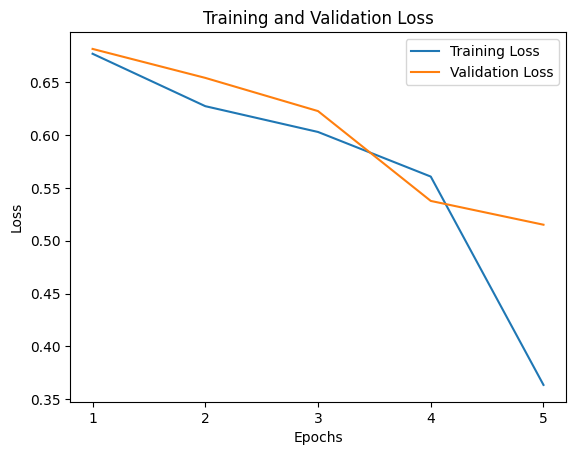

In [37]:
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, valid_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(arange(1, 6, 1))
plt.legend(loc='best')
plt.show()

#### Step 11: Check Metrics for the Best Model

In [38]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tweets. If tweets are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64


{'eval_loss': 0.5151525735855103,
 'eval_f1': 0.7612847222222223,
 'eval_recall': 0.7803308823529411,
 'eval_precision': 0.7541666666666667,
 'eval_runtime': 3.611,
 'eval_samples_per_second': 55.387,
 'eval_steps_per_second': 1.108,
 'epoch': 5.0}

In [39]:
trainer.save_model() #save model

Saving model checkpoint to ./model_disaster/results
Configuration saved in ./model_disaster/results/config.json
Model weights saved in ./model_disaster/results/pytorch_model.bin


#### Step 12: Identify Missclassified Tweets in the Train Data

In [40]:
test_text = our_dataset['test']['tweets'] #list of tweets in train data
test_labels = our_dataset['test']['label'] #list of tweets in test data

In [41]:
pipe = pipeline("text-classification", "./model_disaster/results", tokenizer=tokenizer)

loading configuration file ./model_disaster/results/config.json
Model config RobertaConfig {
  "_name_or_path": "./model_disaster/results",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": 0,
    "1": 1
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": null,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading configuration file ./model_disaster/results/config.json
Model config RobertaConfig {
  "_

In [42]:
preds = pipe(test_text)

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [43]:
pred_labels = []

for p in preds:
    pred_labels.append(p['label'])   

In [44]:
miss_classified_inds = []

for ind in range(len(test_labels)): 
    if pred_labels[ind]!=test_labels[ind]: 
        miss_classified_inds.append(ind) 

In [45]:
missclassfied_text = []
for ind in miss_classified_inds: 
    r = {
        'text': test_text[ind],
        'label': test_labels[ind], 
        'pred': pred_labels[ind] 
    }
    missclassfied_text.append(r)

In [46]:
missclassfied_df = pd.DataFrame(missclassfied_text)
print("Missclassified Tweets:")
missclassfied_df.head(3)

Missclassified Tweets:


,text,label,pred
0,guaranteed been bitten by some mutant mosquito my ankle has blown up. little cunts,0,1
1,stay vigilent. civil liberties are under constant attack. #nativehuman #myreligion,1,0
2,owner of chicago-area gay bar admits to arson scheme via #lgbt,0,1


#### Step 13: Explore Additional Metrics for Model Performance

In [47]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       136
           1       0.62      0.78      0.69        64

    accuracy                           0.78       200
   macro avg       0.75      0.78      0.76       200
weighted avg       0.80      0.78      0.79       200



In [48]:
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels, labels=None, sample_weight=None, normalize=None)

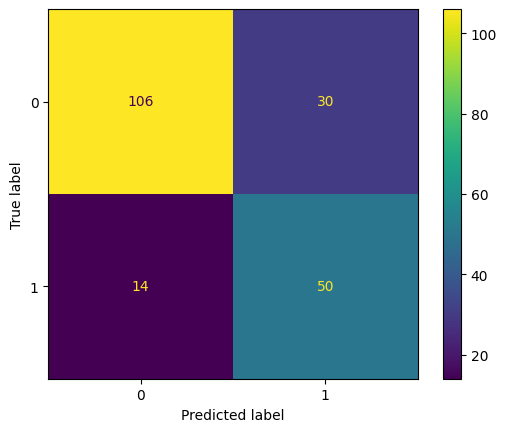

In [49]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()